# Civil Engineering Machine Learning Project


***
## 1. Data Extraction

In [2]:
"""
Created on Tue Jul 18 03:12:39 2017

@author: Aamir
"""
%matplotlib inline

### Import Libraries

In [3]:

import os
import scipy.io
import numpy as np
import pandas as pd
from math import log10, floor
from datetime import datetime

import keras
from keras.layers import Dense, Dropout, Activation
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import metrics
import xgboost as xgb

from IPython.display import SVG
import matplotlib.pyplot as plt

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

### Load Excel files

In [5]:
temp1 = pd.read_excel("Type 1.xlsx", sheetname="B1")
temp2 = pd.read_excel("Type 1.xlsx", sheetname="B2")
temp3 = pd.read_excel("Type 1.xlsx", sheetname="B3")

In [6]:
temp1.shape, temp2.shape, temp3.shape

((258735, 37), (138661, 42), (162644, 20))

### Clean Columns/Rows

In [7]:
train_set = temp1.iloc[:,0:20]
test_set = temp2.iloc[:,0:21]

In [8]:
train_set = train_set[train_set.ID!='ID']
train_set.dropna(inplace=True)
test_set = test_set[test_set.ID!='ID']
test_set.dropna(inplace=True)

In [9]:
train_set.shape, test_set.shape

((127718, 20), (68534, 21))

In [10]:
test_set['SIG-STRNGTH'] = (test_set["SIG"].astype(str).map(str) + test_set["STRNGTH"].astype(str)).astype(float)
test_set.drop('SIG',axis=1,inplace=True)
test_set.drop('STRNGTH',axis=1,inplace=True)

In [11]:
test_set = test_set[train_set.columns]

### Merge two tables

In [12]:
combined_set = pd.concat([train_set,test_set])

In [13]:
combined_set.reset_index(drop=True,inplace=True)

### Datatype integrity check

In [14]:
combined_set['ID'] = combined_set['ID'].astype(int)
combined_set['DDD'] = combined_set['DDD'].astype(int)
combined_set['PARA1'] = combined_set['PARA1'].astype(float)
combined_set['CH'] = combined_set['CH'].astype(int)
combined_set['RISE'] = combined_set['RISE'].astype(int)
combined_set['COUN'] = combined_set['COUN'].astype(int)
combined_set['ENER'] = combined_set['ENER'].astype(int)
combined_set['DURATION'] = combined_set['DURATION'].astype(int)
combined_set['AMP'] = combined_set['AMP'].astype(int)
combined_set['A-FRQ'] = combined_set['A-FRQ'].astype(int)
combined_set['RMS'] = combined_set['RMS'].astype(float)
combined_set['ASL'] = combined_set['ASL'].astype(int)
combined_set['PCNTS'] = combined_set['PCNTS'].astype(int)
combined_set['THR'] = combined_set['THR'].astype(int)
combined_set['R-FRQ'] = combined_set['R-FRQ'].astype(int)
combined_set['I-FRQ'] = combined_set['I-FRQ'].astype(int)
combined_set['SIG-STRNGTH'] = combined_set['SIG-STRNGTH'].astype(float)
combined_set['ABS-ENERGY'] = combined_set['ABS-ENERGY'].astype(float)
combined_set['DAMAGE'] = combined_set['DAMAGE'].astype(int)

combined_set.dtypes

ID                    int32
DDD                   int32
HH:MM:SS.mmmuuun     object
PARA1               float64
CH                    int32
RISE                  int32
COUN                  int32
ENER                  int32
DURATION              int32
AMP                   int32
A-FRQ                 int32
RMS                 float64
ASL                   int32
PCNTS                 int32
THR                   int32
R-FRQ                 int32
I-FRQ                 int32
SIG-STRNGTH         float64
ABS-ENERGY          float64
DAMAGE                int32
dtype: object

In [15]:
combined_set.to_excel("combinedData.xlsx")

### Feature engineering

In [16]:
combined_set['HR'] = combined_set['HH:MM:SS.mmmuuun'].apply(lambda x: x.hour)
combined_set['MIN'] = combined_set['HH:MM:SS.mmmuuun'].apply(lambda x: x.minute)
combined_set['SEC'] = combined_set['HH:MM:SS.mmmuuun'].apply(lambda x: x.second)
combined_set['USEC'] = combined_set['HH:MM:SS.mmmuuun'].apply(lambda x: x.microsecond)

In [17]:
combined_set.drop('HH:MM:SS.mmmuuun',axis=1,inplace=True)
combined_set.head()

,ID,DDD,PARA1,CH,RISE,COUN,ENER,DURATION,AMP,A-FRQ,...,THR,R-FRQ,I-FRQ,SIG-STRNGTH,ABS-ENERGY,DAMAGE,HR,MIN,SEC,USEC
0,1,0,0.0143,2,21,4,2,134,51,30,...,45,17,95,13088.00,202.701,1,0,1,13,212000
1,1,0,0.0131,4,9,5,2,114,52,44,...,45,38,111,14372.00,260.846,1,0,1,13,505000
2,1,0,0.0131,2,1,1,0,2,47,500,...,45,0,1000,283.65,6.438,1,0,1,14,793000
3,1,0,0.0119,2,1,2,0,55,45,36,...,45,18,1000,4188.00,52.109,1,0,1,14,918000
4,1,0,0.0092,2,27,12,8,442,57,27,...,45,24,74,51280.00,1296.000,1,0,1,15,187000


In [18]:
X_combined = combined_set.copy()
y_combined = X_combined.pop('DAMAGE')
X_combined.shape

(196252, 22)

In [19]:
y_combined.shape

(196252,)

### Split Training/Validation/Test Sets

In [20]:
X_train, X_temp, y_train, y_temp = train_test_split(X_combined, y_combined, test_size=0.1)

In [21]:
X_train.shape, X_temp.shape, y_train.shape, y_temp.shape

((176626, 22), (19626, 22), (176626,), (19626,))

In [22]:
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=10000)

In [23]:
X_valid.shape, X_test.shape, y_valid.shape, y_test.shape

((9626, 22), (10000, 22), (9626,), (10000,))

At the end, we have three sets
- Training set (176626,22) and (176626,)
- Validation set (9626,22) and (9626,)
- Test set (10000,22) and (10000,)

***
## 2. Train the Model

### MODEL 1

In [74]:
model1 = RandomForestClassifier(max_depth=10, min_samples_split=2, n_estimators=50, random_state=1)
model1 = model1.fit(X_train.values, y_train)

In [75]:
print(model1.feature_importances_)
print(model1.score(X_valid.values, y_valid))

[  0.00000000e+00   0.00000000e+00   7.48622055e-04   1.38334061e-02
   1.42813621e-03   2.77676161e-03   1.19353925e-03   2.95508981e-03
   6.97906382e-04   1.55935702e-03   1.28939507e-02   1.24620393e-02
   1.68851761e-03   0.00000000e+00   1.50975304e-03   1.30984337e-03
   3.20080162e-03   1.74837113e-03   0.00000000e+00   9.01034643e-01
   3.76110916e-02   1.34817009e-03]
0.938499896115


In [76]:
prediction1 = model1.predict(X_test)
np.mean(prediction1 == y_test)

0.93640000000000001

### MODEL 2

In [77]:
model2 = RandomForestClassifier(n_estimators=50, max_features='sqrt')
model2 = model2.fit(X_train,y_train)

In [78]:
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = model2.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

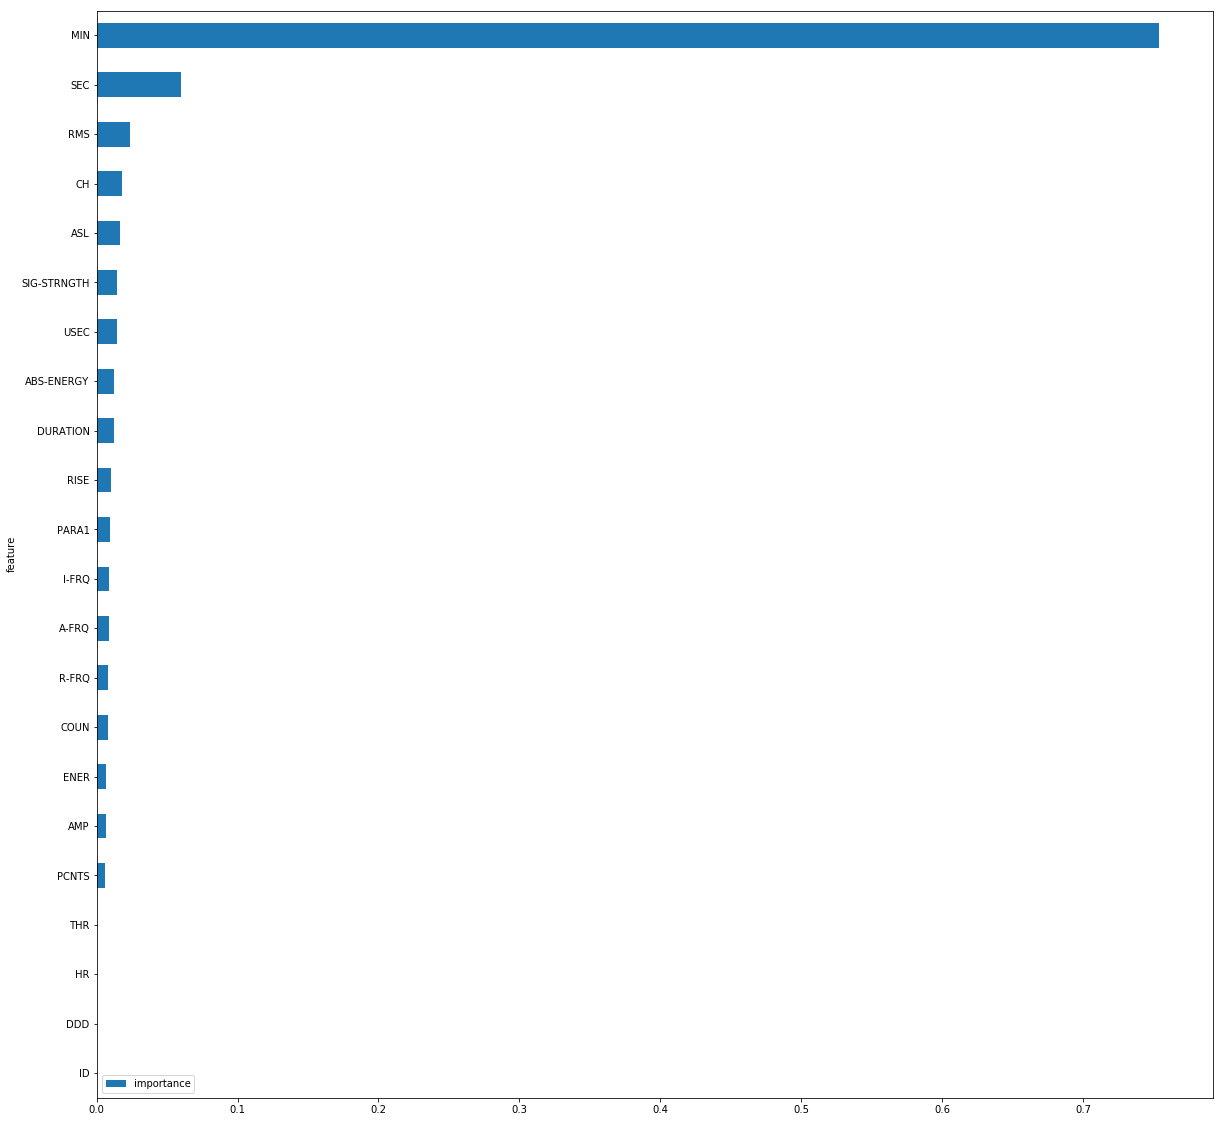

In [79]:
features.plot(kind='barh', figsize=(20, 20))

In [80]:
h_test = model2.predict(X_test)

In [81]:
np.mean(h_test == y_test)

0.97619999999999996

In [82]:
res = pd.DataFrame(h_test,y_test) 

In [33]:
res.to_excel("result.xlsx")

### MODEL 3

In [34]:
parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50,
                'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}
model3 = RandomForestClassifier(**parameters)
model3.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [35]:
xval = cross_val_score(model3, X_valid, y_valid, cv = 5, scoring='accuracy')
np.mean(xval)

0.86027590117631614

In [36]:
h_test = model3.predict(X_test)

In [37]:
np.mean(h_test == y_test)

0.85229999999999995

In [38]:
pd.DataFrame(h_test, y_test)

,0
DAMAGE,
3,3
1,3
1,3
2,3
4,4
3,3
4,4
2,3
3,3


***
## 3. Predict New Data

### Clean data

In [41]:
temp3.shape

(162644, 20)

In [61]:
new_set = temp3.iloc[:,0:19]

In [62]:
new_set = new_set[new_set.ID!='ID']
new_set.dropna(inplace=True)

In [65]:
new_set.reset_index(drop=True,inplace=True)

In [67]:
new_set['ID'] = new_set['ID'].astype(int)
new_set['DDD'] = new_set['DDD'].astype(int)
new_set['PARA1'] = new_set['PARA1'].astype(float)
new_set['CH'] = new_set['CH'].astype(int)
new_set['RISE'] = new_set['RISE'].astype(int)
new_set['COUN'] = new_set['COUN'].astype(int)
new_set['ENER'] = new_set['ENER'].astype(int)
new_set['DURATION'] = new_set['DURATION'].astype(int)
new_set['AMP'] = new_set['AMP'].astype(int)
new_set['A-FRQ'] = new_set['A-FRQ'].astype(int)
new_set['RMS'] = new_set['RMS'].astype(float)
new_set['ASL'] = new_set['ASL'].astype(int)
new_set['PCNTS'] = new_set['PCNTS'].astype(int)
new_set['THR'] = new_set['THR'].astype(int)
new_set['R-FRQ'] = new_set['R-FRQ'].astype(int)
new_set['I-FRQ'] = new_set['I-FRQ'].astype(int)
new_set['SIG-STRNGTH'] = new_set['SIG-STRNGTH'].astype(float)
new_set['ABS-ENERGY'] = new_set['ABS-ENERGY'].astype(float)

In [69]:
new_set['HR'] = new_set['HH:MM:SS.mmmuuun'].apply(lambda x: x.hour)
new_set['MIN'] = new_set['HH:MM:SS.mmmuuun'].apply(lambda x: x.minute)
new_set['SEC'] = new_set['HH:MM:SS.mmmuuun'].apply(lambda x: x.second)
new_set['USEC'] = new_set['HH:MM:SS.mmmuuun'].apply(lambda x: x.microsecond)
new_set.drop('HH:MM:SS.mmmuuun',axis=1,inplace=True)

In [72]:
new_set = new_set[X_combined.columns]

### Make predictions 

In [106]:
pred = model2.predict(new_set)

In [107]:
pred = pd.DataFrame(pred,columns=['DAMAGE'])

In [108]:
result = pd.concat([new_set, pred], axis=1)

In [110]:
result.to_excel('resultDamage.xlsx')

***
***
# Rough Work 

In [ ]:
%matplotlib inline